# プロファイルスキーマ付きチャットボット

## レビュー

長期記憶を保存・取得する方法として[LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore)を紹介しました。

`短期記憶（スレッド内）`と`長期記憶（スレッド間）`の両方を使用するシンプルなチャットボットを構築しました。

ユーザーがチャットしている間に、長期[セマンティックメモリ](https://langchain-ai.github.io/langgraph/concepts/memory/#semantic-memory)（ユーザーに関する事実）を["ホットパス"で](https://langchain-ai.github.io/langgraph/concepts/memory/#writing-memories)保存しました。

## 目標

私たちのチャットボットは、メモリを文字列として保存していました。実際には、メモリに構造を持たせたい場合がよくあります。

例えば、メモリは[単一の継続的に更新されるスキーマ](https://langchain-ai.github.io/langgraph/concepts/memory/#profile)にできます。

この場合、単一のユーザープロファイルにしたいと考えます。

チャットボットを拡張して、セマンティックメモリを単一の[ユーザープロファイル](https://langchain-ai.github.io/langgraph/concepts/memory/#profile)に保存します。

また、このスキーマを新しい情報で更新するためのライブラリ[Trustcall](https://github.com/hinthornw/trustcall)も紹介します。

In [7]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [1]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## ユーザープロファイルスキーマの定義

Pythonには[構造化データ](https://python.langchain.com/docs/concepts/structured_outputs/#schema-definition)用の多くの異なるタイプがあります。TypedDict、辞書、JSON、[Pydantic](https://docs.pydantic.dev/latest/)などです。

まず、TypedDictを使用してユーザープロファイルスキーマを定義しましょう。

In [3]:
from typing import TypedDict, List

class UserProfile(TypedDict):
    """User profile schema with typed fields"""
    user_name: str  # The user's preferred name
    interests: List[str]  # A list of the user's interests

## スキーマのストアへの保存

[LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore)は任意のPython辞書を`value`として受け入れます。

In [4]:
# TypedDict instance
user_profile: UserProfile = {
    "user_name": "Lance",
    "interests": ["biking", "technology", "coffee"]
}
user_profile

{'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}

[put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put)メソッドを使用してTypedDictをストアに保存します。

In [5]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memory")

# Save a memory to namespace as key and value
key = "user_profile"
value = user_profile
in_memory_store.put(namespace_for_memory, key, value)

[search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search)を使用して、名前空間でストアからオブジェクトを取得します。

In [6]:
# Search 
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'value': {'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}, 'key': 'user_profile', 'namespace': ['1', 'memory'], 'created_at': '2024-11-04T23:37:34.871675+00:00', 'updated_at': '2024-11-04T23:37:34.871680+00:00'}


[get](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.get)を使用して、名前空間とキーで特定のオブジェクトを取得することもできます。

In [7]:
# Get the memory by namespace and key
profile = in_memory_store.get(namespace_for_memory, "user_profile")
profile.value

{'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}

## プロファイルスキーマ付きチャットボット

メモリのスキーマを指定してストアに保存する方法がわかりました。

では、実際にこの特定のスキーマでメモリを*作成*するにはどうすればよいでしょうか？

私たちのチャットボットでは、[ユーザーチャットからメモリを作成したい](https://langchain-ai.github.io/langgraph/concepts/memory/#profile)と考えています。

ここで[構造化出力](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage)の概念が有用です。

LangChainの[チャットモデル](https://python.langchain.com/docs/concepts/chat_models/)インターフェースには、構造化出力を強制する[`with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage)メソッドがあります。

これは、出力がスキーマに準拠することを強制し、出力を解析してくれるため便利です。

In [7]:
_set_env("OPENAI_API_KEY")

作成した`UserProfile`スキーマを`with_structured_output`メソッドに渡してみましょう。

その後、[メッセージ](https://python.langchain.com/docs/concepts/messages/)のリストでチャットモデルを起動し、スキーマに準拠した構造化出力を取得できます。

In [8]:
from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Bind schema to model
model_with_structure = model.with_structured_output(UserProfile)

# Invoke the model to produce structured output that matches the schema
structured_output = model_with_structure.invoke([HumanMessage("My name is Lance, I like to bike.")])
structured_output

{'user_name': 'Lance', 'interests': ['biking']}

これをチャットボットで使用してみましょう。

これには`write_memory`関数への軽微な変更のみが必要です。

上記で定義した`model_with_structure`を使用して、スキーマに一致するプロファイルを生成します。

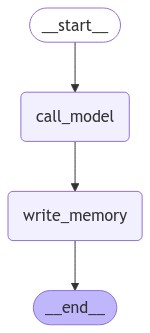

In [9]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """Create or update a user profile memory based on the user's chat history. 
This will be saved for long-term memory. If there is an existing memory, simply update it. 
Here is the existing memory (it may be empty): {memory}"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None
        
    # Format the existing memory in the instruction
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)

    # Invoke the model to produce structured output that matches the schema
    new_memory = model_with_structure.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing use profile memory
    key = "user_memory"
    store.put(namespace, key, new_memory)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [10]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance and I like to bike around San Francisco and eat at bakeries.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance and I like to bike around San Francisco and eat at bakeries.
================================== Ai Message ==================================

Hi Lance! It's great to meet you. Biking around San Francisco sounds like a fantastic way to explore the city, and there are so many amazing bakeries to try. Do you have any favorite bakeries or biking routes in the city?


ストア内のメモリを確認してみましょう。

メモリが私たちのスキーマに一致する辞書であることがわかります。

In [11]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.value

{'user_name': 'Lance', 'interests': ['biking', 'bakeries', 'San Francisco']}

## いつ失敗するか？

[`with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage)は非常に有用ですが、より複雑なスキーマを扱う場合はどうなるでしょうか？

[こちら](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema)は、より複雑なスキーマの例で、以下でテストします。

これは、ユーザーのコミュニケーションと信頼ゲームの設定を説明する[Pydantic](https://docs.pydantic.dev/latest/)モデルです。

In [18]:
from typing import List, Optional

class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str

class TelegramPreferences(BaseModel):
    preferred_encoding: Optional[List[OutputFormat]] = None
    favorite_telegram_operators: Optional[List[OutputFormat]] = None
    preferred_telegram_paper: Optional[List[OutputFormat]] = None

class MorseCode(BaseModel):
    preferred_key_type: Optional[List[OutputFormat]] = None
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None

class Semaphore(BaseModel):
    preferred_flag_color: Optional[List[OutputFormat]] = None
    semaphore_skill_level: Optional[List[OutputFormat]] = None

class TrustFallPreferences(BaseModel):
    preferred_fall_height: Optional[List[OutputFormat]] = None
    trust_level: Optional[List[OutputFormat]] = None
    preferred_catching_technique: Optional[List[OutputFormat]] = None

class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore

class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences

class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

`with_structured_output`メソッドを使用して、このスキーマの抽出を試してみましょう。

In [19]:
from pydantic import ValidationError

# Bind schema to model
model_with_structure = model.with_structured_output(TelegramAndTrustFallPreferences)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

# Invoke the model
try:
    model_with_structure.invoke(f"""Extract the preferences from the following conversation:
    <convo>
    {conversation}
    </convo>""")
except ValidationError as e:
    print(e)

1 validation error for TelegramAndTrustFallPreferences
pertinent_user_preferences.communication_preferences.semaphore
  Input should be a valid dictionary or instance of Semaphore [type=model_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type


`gpt-4o`のような高性能モデルを使用しても、複雑なスキーマを単純に抽出しようとすると失敗しやすくなります。

## プロファイルスキーマの作成と更新のためのTrustcall

ご覧のように、スキーマの操作は厄介な場合があります。

複雑なスキーマは抽出が困難な場合があります。

さらに、単純なスキーマであっても更新には課題があります。

上記のチャットボットを考えてみてください。

新しいメモリを保存することを選択するたびに、プロファイルスキーマを*ゼロから*再生成していました。

これは非効率的で、スキーマに毎回再生成する大量の情報が含まれている場合、モデルトークンを無駄にする可能性があります。

さらに悪いことに、プロファイルをゼロから再生成する際に情報を失う可能性があります。

これらの問題に対処することが[TrustCall](https://github.com/hinthornw/trustcall)の動機です！

これは、LangChainチームの[Will Fu-Hinthorn](https://github.com/hinthornw)によって開発されたJSONスキーマ更新用のオープンソースライブラリです。

これは、メモリに関する作業中に正にこれらの課題によって動機づけられました。

まず、この[メッセージ](https://python.langchain.com/docs/concepts/messages/)リストでTrustCallを使用した単純な抽出の使用法を示しましょう。

In [20]:
# Conversation
conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="I really like biking around San Francisco.")]

`create_extractor`を使用し、モデルと[ツール](https://python.langchain.com/docs/concepts/tools/)としてのスキーマを渡します。

TrustCallでは、スキーマを様々な方法で提供できます。

例えば、JSONオブジェクト／Python辞書やPydanticモデルを渡すことができます。

内部的に、TrustCallは[ツール呼び出し](https://python.langchain.com/docs/concepts/tool_calling/)を使用して、入力[メッセージ](https://python.langchain.com/docs/concepts/messages/)のリストから[構造化出力](https://python.langchain.com/docs/concepts/structured_outputs/)を生成します。

Trustcallに[構造化出力](https://python.langchain.com/docs/concepts/structured_outputs/)を強制的に生成させるために、`tool_choice`引数にスキーマ名を含めることができます。

上記の会話で抽出器を起動できます。

In [21]:
from trustcall import create_extractor

# Schema 
class UserProfile(BaseModel):
    """User profile schema with typed fields"""
    user_name: str = Field(description="The user's preferred name")
    interests: List[str] = Field(description="A list of the user's interests")

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile"
)

# Instruction
system_msg = "Extract the user profile from the following conversation"

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+conversation})

抽出器を起動すると、いくつかのものが得られます：

* `messages`：ツール呼び出しを含む`AIMessages`のリスト。
* `responses`：スキーマに一致する結果の解析されたツール呼び出し。
* `response_metadata`：既存のツール呼び出しを更新する場合に適用可能。どの応答がどの既存オブジェクトに対応するかを示します。

In [17]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_spGGUsoaUFXU7oOrUNCASzfL)
 Call ID: call_spGGUsoaUFXU7oOrUNCASzfL
  Args:
    user_name: Lance
    interests: ['biking around San Francisco']


In [18]:
schema = result["responses"]
schema

[UserProfile(user_name='Lance', interests=['biking around San Francisco'])]

In [19]:
schema[0].model_dump()

{'user_name': 'Lance', 'interests': ['biking around San Francisco']}

In [20]:
result["response_metadata"]

[{'id': 'call_spGGUsoaUFXU7oOrUNCASzfL'}]

プロファイルを*更新*するためにどのように使用できるかを見てみましょう。

更新の場合、TrustCallはメッセージのセットと既存のスキーマを取ります。

中心的なアイデアは、スキーマの関連部分のみを更新するための[JSON Patch](https://jsonpatch.com/)を生成するようにモデルにプロンプトすることです。

これは、スキーマ全体を単純に上書きするよりもエラーが少なくなります。

また、モデルは変更された部分のみを生成すれば良いため、より効率的です。

既存のスキーマを辞書として保存できます。

`model_dump()`を使用してPydanticモデルインスタンスを辞書にシリアル化できます。

これをスキーマ名`UserProfile`と共に`"existing"`引数に渡します。

In [21]:
# Update the conversation
updated_conversation = [HumanMessage(content="Hi, I'm Lance."), 
                        AIMessage(content="Nice to meet you, Lance."), 
                        HumanMessage(content="I really like biking around San Francisco."),
                        AIMessage(content="San Francisco is a great city! Where do you go after biking?"),
                        HumanMessage(content="I really like to go to a bakery after biking."),]

# Update the instruction
system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+updated_conversation}, 
                                    {"existing": {"UserProfile": schema[0].model_dump()}})  

In [22]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_WeZl0ACfQStxblim0ps8LNKT)
 Call ID: call_WeZl0ACfQStxblim0ps8LNKT
  Args:
    user_name: Lance
    interests: ['biking', 'visiting bakeries']


In [23]:
result["response_metadata"]

[{'id': 'call_WeZl0ACfQStxblim0ps8LNKT'}]

In [24]:
updated_schema = result["responses"][0]
updated_schema.model_dump()

{'user_name': 'Lance', 'interests': ['biking', 'visiting bakeries']}

LangSmithトレース：

https://smith.langchain.com/public/229eae22-1edb-44c6-93e6-489124a43968/r

では、以前に見た[挑戦的なスキーマ](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema)でもTrustcallをテストしてみましょう。

In [25]:
bound = create_extractor(
    model,
    tools=[TelegramAndTrustFallPreferences],
    tool_choice="TelegramAndTrustFallPreferences",
)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

result = bound.invoke(
    f"""Extract the preferences from the following conversation:
<convo>
{conversation}
</convo>"""
)

# Extract the preferences
result["responses"][0]

TelegramAndTrustFallPreferences(pertinent_user_preferences=UserPreferences(communication_preferences=CommunicationPreferences(telegram=TelegramPreferences(preferred_encoding=[OutputFormat(preference='standard encoding', sentence_preference_revealed='standard encoding')], favorite_telegram_operators=None, preferred_telegram_paper=[OutputFormat(preference='Daredevil', sentence_preference_revealed='Daredevil')]), morse_code=MorseCode(preferred_key_type=[OutputFormat(preference='straight key', sentence_preference_revealed='straight key')], favorite_morse_abbreviations=None), semaphore=Semaphore(preferred_flag_color=None, semaphore_skill_level=None)), trust_fall_preferences=TrustFallPreferences(preferred_fall_height=[OutputFormat(preference='higher', sentence_preference_revealed='higher')], trust_level=None, preferred_catching_technique=[OutputFormat(preference='diamond formation', sentence_preference_revealed='diamond formation')])))

トレース：

https://smith.langchain.com/public/5cd23009-3e05-4b00-99f0-c66ee3edd06e/r

その他の例については、概要ビデオを[こちら](https://www.youtube.com/watch?v=-H4s0jQi-QY)で見ることができます。

## プロファイルスキーマ更新付きチャットボット

では、Trustcallをチャットボットに導入して、メモリプロファイルの作成*と更新*を行いましょう。

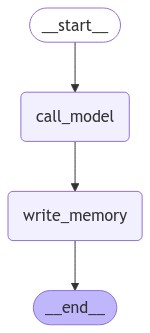

In [22]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Schema 
class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile", # Enforces use of the UserProfile tool
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Extraction instruction
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"      
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Get the profile as the value from the list, and convert it to a JSON doc
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None
    
    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]+state["messages"], "existing": existing_profile})
    
    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump()

    # Save the updated profile
    key = "user_memory"
    store.put(namespace, key, updated_profile)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [23]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hello, Lance! It's nice to meet you. How can I assist you today?


In [24]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a great way to explore the city! San Francisco has some beautiful routes and views. Do you have any favorite trails or spots you like to visit while biking?


In [25]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'value': {'user_name': 'Lance',
  'user_location': 'San Francisco',
  'interests': ['biking']},
 'key': 'user_memory',
 'namespace': ['memory', '1'],
 'created_at': '2024-11-04T23:51:17.662428+00:00',
 'updated_at': '2024-11-04T23:51:41.697652+00:00'}

In [26]:
# The user profile saved as a JSON object
existing_memory.value

{'user_name': 'Lance',
 'user_location': 'San Francisco',
 'interests': ['biking']}

In [27]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

Biking and visiting bakeries sounds like a delightful combination! San Francisco has some fantastic bakeries. Do you have any favorites, or are you looking for new recommendations to try out?


新しいスレッドで会話を続けます。

In [28]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

Since you're in San Francisco and enjoy going to bakeries, here are a few recommendations you might like:

1. **Tartine Bakery** - Known for its delicious bread and pastries, it's a must-visit for any bakery enthusiast.
2. **B. Patisserie** - Offers a delightful selection of French pastries, including their famous kouign-amann.
3. **Arsicault Bakery** - Renowned for its croissants, which have been praised as some of the best in the country.
4. **Craftsman and Wolves** - Known for their inventive pastries and the "Rebel Within," a savory muffin with a soft-cooked egg inside.
5. **Mr. Holmes Bakehouse** - Famous for their cruffins and other creative pastries.

These spots should offer a great variety of treats for you to enjoy. Happy bakery hopping!


トレース：

https://smith.langchain.com/public/f45bdaf0-6963-4c19-8ec9-f4b7fe0f68ad/r

## Studio

![Screenshot 2024-10-30 at 11.26.31 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732d0437060f1754ea79908_Screenshot%202024-11-11%20at%207.48.53%E2%80%AFPM.png)